# Tarea realizada por Jesús Martínez Leal
Última edición: 15/02/2024

In [25]:
%matplotlib inline


# Multi-dimensional scaling

Utilizaremos el dataset de caras de Olivetti de AT&T para aprender embeddings en un espacio de 2 dimensiones. El dataset tiene 10 imágenes de 64x64 por persona, cada imagen adquirida con diferentes expresiones faciales o condiciones de iluminación. 

Al aplicar MDS pretendemos que se preserven los patrones de los datos de manera que imágenes de caras de la misma persona estén cerca, pero lejos de las caras del resto de personas. 

Para que se pueda ver correctamente, se cogerán caras de únicamente 4 personas.

Para ver los diferentes parámetros de entrada del algoritmo MDS:

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

In [26]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import sklearn.datasets as dt
import seaborn as sns         
import numpy as np
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Antes de aplicar MDS, escribiremos un pequeña función, mapeaDatos(), que representa los puntos transformados en 2D, con el mismo color para los puntos de la misma persona. En la segunda figura representa la imagen de cada cara sobre el gráfico en el espacio de baja dimensionalidad.

In [27]:
def mapeaDatos(Y, X, y, titulo):

    # Plot the embedding, colored according to the class of the points
    fig = plt.figure(2, (15,6))
    ax = fig.add_subplot(1,2,1)    
    ax = sns.scatterplot(x=Y[:, 0], y=Y[:, 1],
                         hue=y, palette=['r', 'g', 'b', 'c'])

    # Add the second plot
    ax = fig.add_subplot(1,2,2)
    # Plot the points again
    plt.scatter(Y[:, 0], Y[:, 1])
    
    # Annotate each point by its corresponding face image
    for x, ind in zip(X, range(Y.shape[0])):
        im = x.reshape(64,64)
        imagebox = OffsetImage(im, zoom=0.3, cmap=plt.cm.gray)
        i = Y[ind, 0]
        j = Y[ind, 1]
        ab = AnnotationBbox(imagebox, (i, j), frameon=False)
        ax.add_artist(ab)
    plt.title(titulo)    
    plt.show()

Elegimos las caras de 4 personas:

In [28]:
caras = dt.fetch_olivetti_faces()
X_caras = caras.data
y_caras = caras.target
ind = y_caras < 4
X_caras = X_caras[ind,:]
y_caras = y_caras[ind]
print(X_caras.shape)

(40, 4096)


Vamos a aplicar MDS de manera manual, paso por paso.

### 1.- Matriz de proximidad 

Implementa una función que calcule la función de proximidad S mediante funciones numpy.

Hacemos un doble bucle para calcular cada elemento de dicha matriz.

In [29]:
def calcular_normas_entre_pares(matriz):
    """
    Calcula la norma entre pares de vectores en una matriz dada.

    Parámetros:
        matriz: numpy.ndarray
            La matriz que contiene los vectores. Debe tener forma (n, m),
            donde n es el número de vectores y m es la longitud de cada vector.

    Devuelve:
        numpy.ndarray
            Una matriz de forma (n, n) que contiene las normas entre pares
            de vectores en la matriz original.
    """
    num_vectores = matriz.shape[0]
    normas_entre_pares = np.zeros((num_vectores, num_vectores))
    
    for i in range(num_vectores):
        for j in range(num_vectores):
            normas_entre_pares[i, j] = np.linalg.norm(matriz[i] - matriz[j])
    
    return normas_entre_pares

In [30]:
S = calcular_normas_entre_pares(X_caras)

Muestra la matriz de proximidad.

In [31]:
def mostrar_matriz(matriz, title, label = None):
    """
    Muestra una matriz utilizando imshow.

    Parámetros:
        matriz: numpy.ndarray
            La matriz que se va a mostrar.
    """
    plt.imshow(matriz, cmap='hot', interpolation='nearest')
    plt.colorbar(label=label)
    plt.xlabel('Índice del vector')
    plt.ylabel('Índice del vector')
    plt.title(title)
    plt.show()

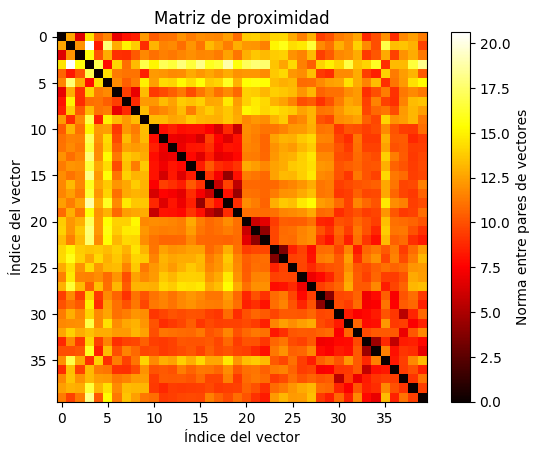

In [32]:
mostrar_matriz(S, title = "Matriz de proximidad", label = "Norma entre pares de vectores")

Comprueba el resultado calculando la misma matriz mediante la función de sklearn `euclidean_distances`. Representa el resultado y comprueba que tu matriz anterior esté bien calculada.

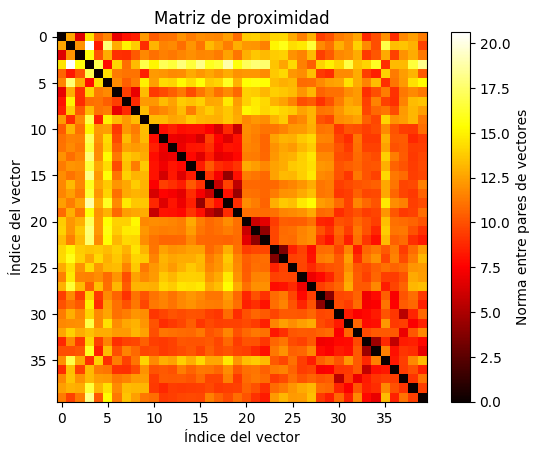

In [33]:
S_sklearn = euclidean_distances(X_caras)
mostrar_matriz(S_sklearn, title = "Matriz de proximidad", label = "Norma entre pares de vectores")

### 2.-  Matriz de centrado

Para asegurar una única solución al problema, debemos centrar los datos de manera que la suma de los valores de todas las filas (y columnas) sea igual a 0. Para ello, construye la matriz de centrado H teniendo en cuenta pesos uniformes para cada cara. Puedes utilizar las funciones numpy `identity`y `full`.

In [34]:
def construir_matriz_centrado(n):
    """
    Construye la matriz de centrado para centrar los datos de manera que la suma de los valores
    de todas las filas y columnas sea igual a 0.

    Parámetros:
        n: int
            El número de vectores en la matriz de datos.

    Devuelve:
        numpy.ndarray
            La matriz de centrado de tamaño (n, n).
    """
    # Construye una matriz identidad de tamaño (n, n)
    
    identidad = np.identity(n)
    
    # Calcula la matriz de centrado utilizando la matriz identidad y la matriz de unos
    
    H = identidad - np.full((n, n), 1 / n)
    
    return H

In [35]:
H = construir_matriz_centrado(n = X_caras.shape[0])

Representa la matriz de centrado.

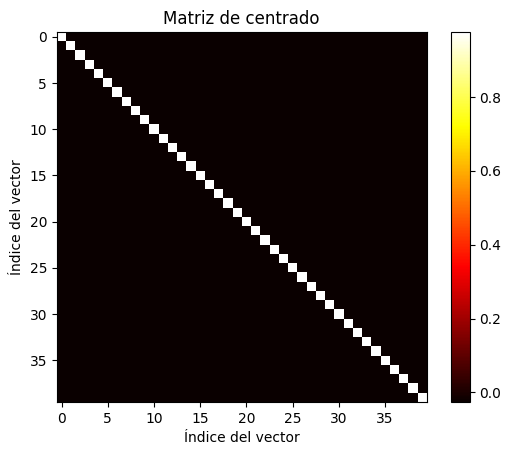

In [36]:
mostrar_matriz(H, title = "Matriz de centrado")

### 3.- Cálculo de la matriz F.

Calcula y representa la matriz F. Puedes utilizar las funciones numpy `matmul` y `transpose`.

In [37]:
F = -0.5 * np.matmul(np.matmul(H, S), H.T)

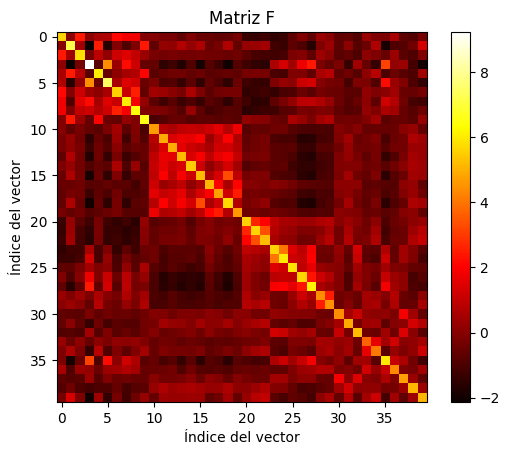

In [38]:
mostrar_matriz(F, title = "Matriz F")

### 4.- Descomposición en valores y vectores propios.

Obtén los autovalores (Lambda) y los autovectores (U) de la matriz F. Puedes utilizar la función numpy `linalg.eig`.

In [39]:
# Obtenemos valores y vectores propios

eigenvalues, U = np.linalg.eig(F)

# Ordenamos los autovalores y autovectores según el valor absoluto en orden decreciente

indices_ordenados = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues = eigenvalues[indices_ordenados]
U = U[:, indices_ordenados]

# Creamos un array con los índices de los autovalores para usarlos como etiquetas
indices = np.arange(len(eigenvalues))

Vamos a plotear los autovalores para ver cómo son.

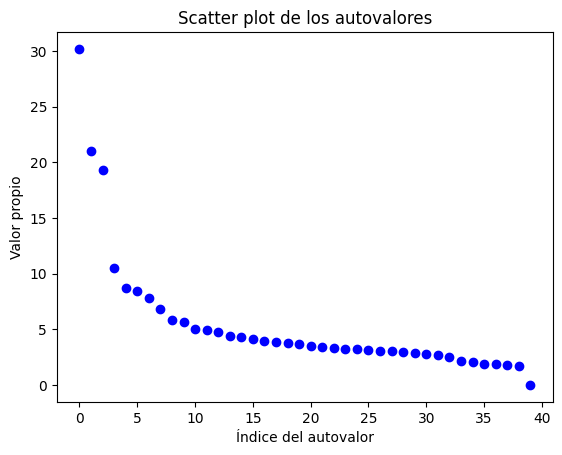

In [40]:
indices = np.arange(len(eigenvalues))
plt.scatter(indices, eigenvalues, color = 'blue')

plt.xlabel('Índice del autovalor')
plt.ylabel('Valor propio')
plt.title('Scatter plot de los autovalores')

plt.show()

### 5.- Obtención de la matriz Y (baja dimensionalidad).

Calcula la matriz Y y representa los resultados del método manual y del método sklearn (función `MDS`) utilizando la función `mapeaDatos`.

In [41]:
# Obtención de la matriz Y

m = 1 / X_caras.shape[0] * np.ones(X_caras.shape,)

Y = np.matmul(np.sqrt(np.linalg.inv(np.diag(m[:,0]))),np.matmul(U,np.sqrt(np.diag(eigenvalues))))

C:\Users\jesus\AppData\Local\Temp\ipykernel_17572\1504999537.py:5: RuntimeWarning: invalid value encountered in sqrt
  Y = np.matmul(np.sqrt(np.linalg.inv(np.diag(m[:,0]))),np.matmul(U,np.sqrt(np.diag(eigenvalues))))


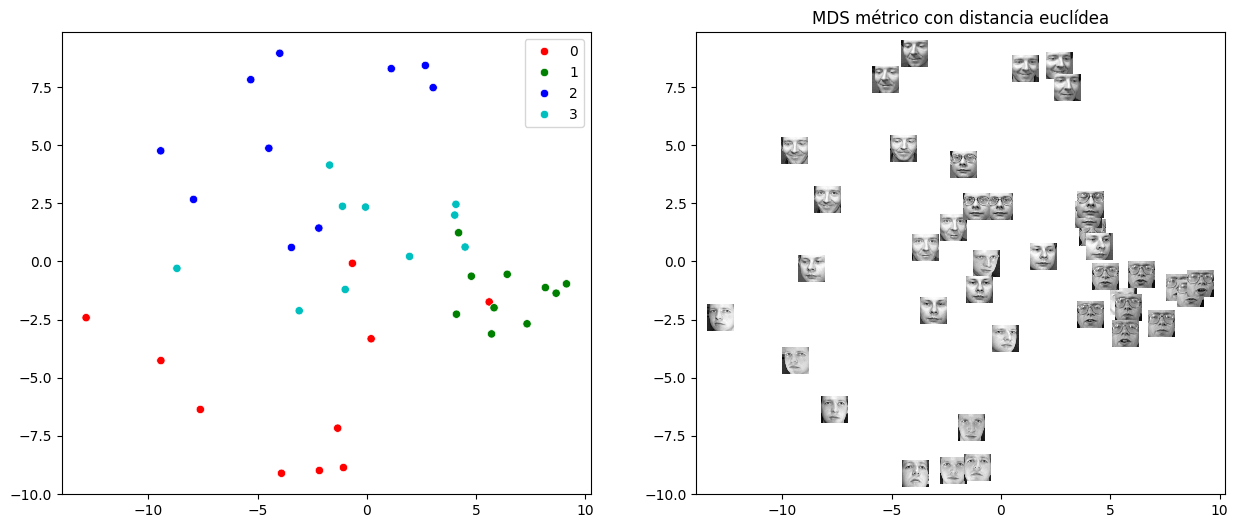

In [42]:
# Representación de los datos
mapeaDatos(Y, X_caras, y_caras, titulo = "MDS métrico con distancia euclídea")

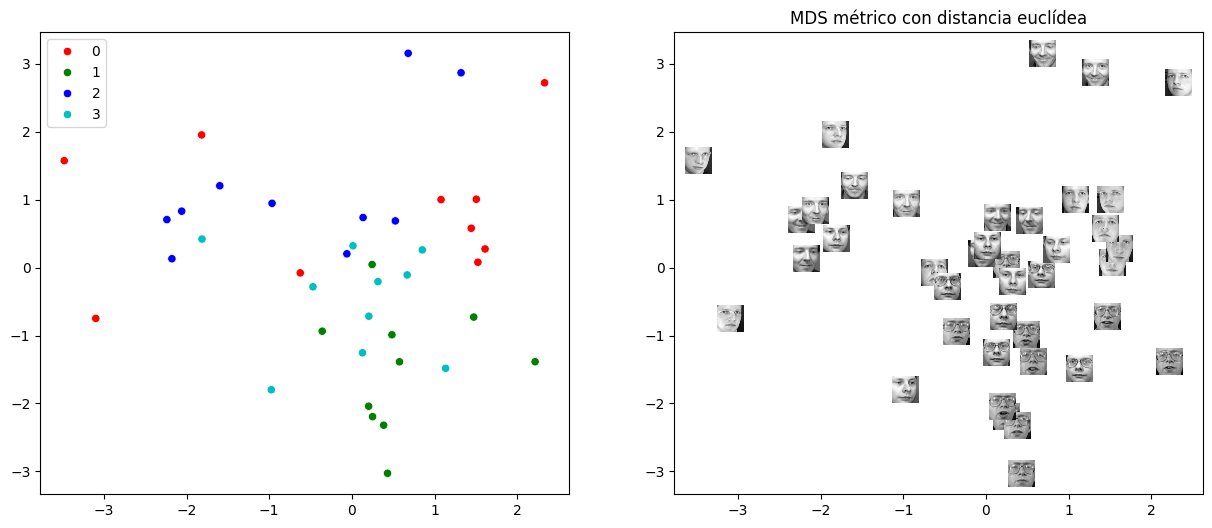

In [43]:
# Utilizando MDS de sklearn

mds = MDS(dissimilarity = 'precomputed', random_state = 0, n_components = X_caras.shape[0])

Y_sklearn = mds.fit_transform(S)

mapeaDatos(Y_sklearn, X_caras, y_caras, titulo = "MDS métrico con distancia euclídea")

¿Qué ocurre? ¿A qué puede ser debido?

### 6.- Bondad (goodness-of-fit)

Para obtener la bondad de la proyección, podemos calcular el stress. Sin embargo, para ello necesitamos las distancias por pares de la proyección. A partir de la matriz Y, representa las coordenadas proyectadas utilizando la fórmula de Euler. 

In [44]:
dist_pares = calcular_normas_entre_pares(Y)

Obtén el stress de Kruskall de la proyección Y. Según la tabla vista en teoría, ¿tendríamos una buena proyección?

In [45]:
def calcular_stress_kruskal(D, Y, n_components=None):
    """
    Calcula el stress de Kruskal dado las distancias por pares en el espacio original y las coordenadas proyectadas Y.

    Parámetros:
        D: numpy.ndarray
            Matriz de distancias por pares en el espacio original.
        Y: numpy.ndarray
            Matriz de coordenadas proyectadas de tamaño (n, d), donde n es el número de puntos
            y d es la dimensionalidad de la proyección.
        n_components: int, opcional
            El número de componentes a considerar al calcular las distancias proyectadas. Si es None, se considerarán todas las componentes.

    Devuelve:
        float
            El stress de Kruskal.
    """
    # Si n_components es None, se considerarán todas las componentes
    if n_components is None:
        n_components = Y.shape[1]

    # Obtenemos el número de puntos
    n = Y.shape[0]

    # Inicializamos la matriz de distancias proyectadas
    distancias_proyectadas = np.zeros((n, n))

    # Calculamos las distancias proyectadas manualmente
    for i in range(n):
        for j in range(n):
            distancias_proyectadas[i, j] = np.linalg.norm(Y[i, :n_components] - Y[j, :n_components])

    # Calculamos el stress de Kruskal
    numerador = np.sum((D - distancias_proyectadas) ** 2)
    denominador = np.sum(D ** 2)
    stress = np.sqrt(numerador / denominador)

    return stress, distancias_proyectadas

In [46]:
stress, distancias_proyectadas = calcular_stress_kruskal(S, Y, n_components = 2)
print(f"El valor de stress de Kruskall es: {stress}")

if stress > 0.2:
    print("Poor goodness-of-fit")
elif 0.1 <= stress <= 0.2:
    print("Fair goodness-of-fit")
elif 0.05 <= stress < 0.1:
    print("Good goodness-of-fit")
elif 0.025 <= stress < 0.05:
    print("Excellent goodness-of-fit")
else:
    print("Perfecto goodness-of-fit")

El valor de stress de Kruskall es: 0.32166782741195593
Poor goodness-of-fit


Compara este valor con el stress obtenido con el algoritmo MDS.

In [47]:
dist_pares_sklearn = calcular_normas_entre_pares(Y_sklearn)

stress_sklearn, distancias_proyectadas_sklearn = calcular_stress_kruskal(S, Y_sklearn, n_components = 2)
print(f"El valor de stress de Kruskall es: {stress_sklearn}")

if stress_sklearn > 0.2:
    print("Poor goodness-of-fit")
elif 0.1 <= stress_sklearn <= 0.2:
    print("Fair goodness-of-fit")
elif 0.05 <= stress_sklearn < 0.1:
    print("Good goodness-of-fit")
elif 0.025 <= stress_sklearn < 0.05:
    print("Excellent goodness-of-fit")
else:
    print("Perfecto goodness-of-fit")

El valor de stress de Kruskall es: 0.781301691028023
Poor goodness-of-fit


Representa las distancias proyectadas vs las distancias originales. ¿El resultado es bueno? ¿Por qué?

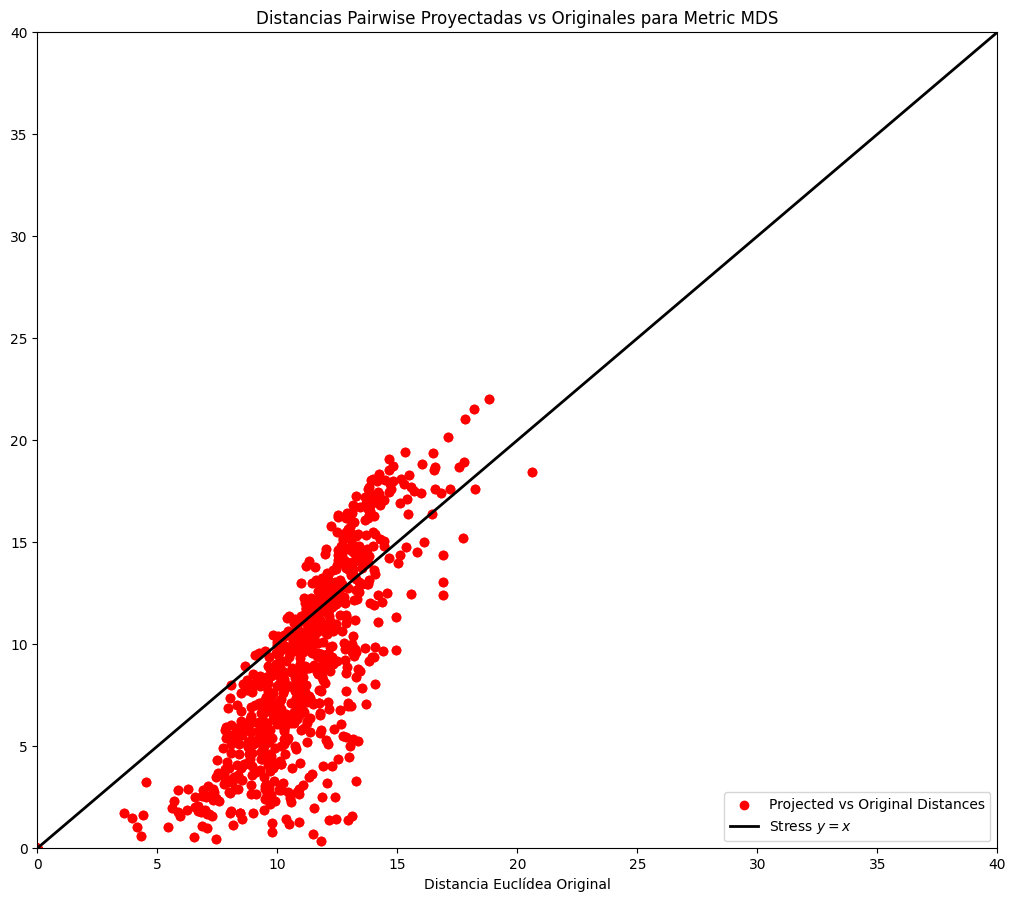

In [48]:
plt.scatter(S, distancias_proyectadas, label = "Projected vs Original Distances", color = "red")

plt.plot(2 * np.max(S) * np.array([0, 1]), 2*np.max(S) * np.array([0, 1]), color = "black", linewidth = 2, label = "Stress $y = x$")
plt.title("Distancias Pairwise Proyectadas vs Originales para Metric MDS");
plt.xlabel("Distancia Euclídea Original", color = "black"); plt.xlim([0, 40]); plt.ylim([0, 40])
plt.legend(loc = "lower right")
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 1.5, top = 1.7, wspace = 0.5, hspace = 0.3)

### 7. Número de componentes

Uno de los hiper-parámetros más importantes relacionados con MDS es el tamaño del espacio de bajas dimensiones. Este factor es relevante si aplicamos MDS como preprocesado para reducir la dimensionalidad. ¿Cuantas dimensiones cogemos sin perder demasiada información?

Para ello, representa el gráfico de sedimentación. Ejecuta MDS con diferente número de componentes (i.e. de 1 a 20) y representa el valor del `stress` en cada caso. 

¿Cuantas componentes escogerías?

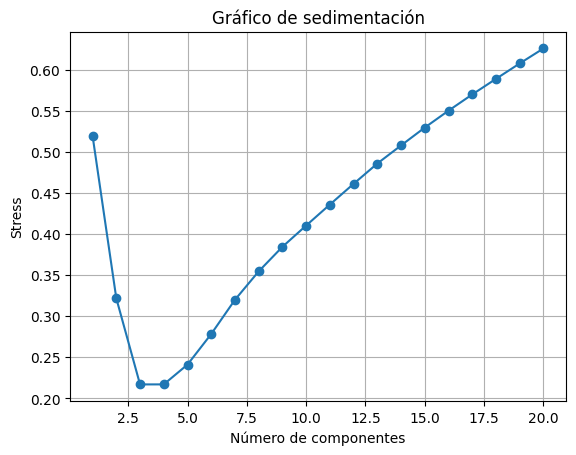

In [49]:
# Lista para almacenar los valores de stress
stress_values = []

# Probamos diferentes números de componentes
for n_components in range(1, 21):
    stress_mds, dist_proyectadas = calcular_stress_kruskal(S, Y, n_components=n_components)
    
    # Guardamos el valor de stress
    stress_values.append(stress_mds)

# Creamos el gráfico de sedimentación
plt.plot(range(1, 21), stress_values, marker='o', linestyle='-')
plt.xlabel('Número de componentes')
plt.ylabel('Stress')
plt.title('Gráfico de sedimentación')
plt.grid(True)
plt.show()

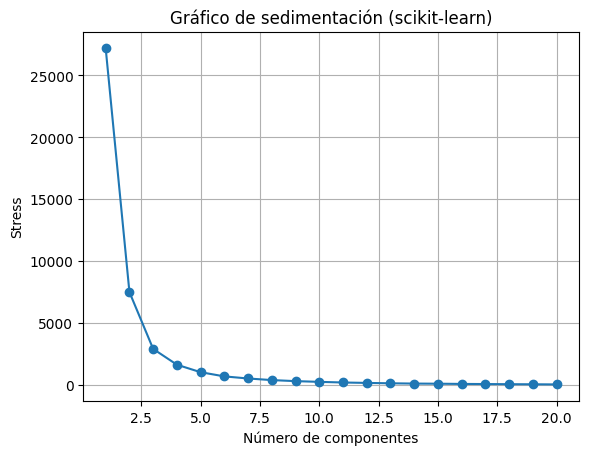

In [50]:
stress_values_sklearn = []

# Probamos diferentes números de componentes
for n_components in range(1, 21):
    
    # Inicializamos MDS con el número actual de componentes
    mds = MDS(n_components=n_components, dissimilarity='precomputed', random_state=0)
    
    # Aplicamos MDS para obtener las coordenadas proyectadas
    Y_mds = mds.fit_transform(S)
    
    # Guardamos el valor de stress
    stress_mds_sklearn = mds.stress_
    stress_values_sklearn.append(stress_mds_sklearn)

# Convertimos stress_values en un arreglo de una dimensión
stress_values_sklearn = np.array(stress_values_sklearn)

# Creamos el gráfico de sedimentación
plt.plot(range(1, 21), stress_values_sklearn, marker='o', linestyle='-')
plt.xlabel('Número de componentes')
plt.ylabel('Stress')
plt.title('Gráfico de sedimentación (scikit-learn)')
plt.grid(True)
plt.show()

## Ejercicios extra utilizando sklearn

#### Ejercicio 1 MDS no métrico

Resuelve el problema utilizando "Non-metric MDS". ¿Observas diferencias en el resultado? ¿Qué stress obtienes?

In [51]:
mds = MDS(metric = False, dissimilarity='precomputed', random_state=0, normalized_stress=True)
pts = mds.fit_transform(S)
mds.stress_

TypeError: MDS.__init__() got an unexpected keyword argument 'normalized_stress'

#### Ejercicio 2 Aplica el algoritmo MDS al dataset `RandomSurveyData`

`RandomSurveyData` contiene los resultados de una encuesta con 15 preguntas diferentes. Las respuestas pueden ser: strongly disagree, disagree, neutral, agree, strongle agree. Aplica el algoritmo **MDS no métrico** con 2 componentes y representa el resultado.  Aplica el algoritmo de clustering `kmeans` y compara los resultados obtenidos poniendo en color los puntos de cada muestra según el cluster al que corresponde.